In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

mpl.rc("figure", dpi=150)
mpl.rc("figure", figsize=(4,4))

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'xtick.labelsize':15,
    'ytick.labelsize':15,
    'axes.labelsize':20,
})

import os

In [2]:
# extra stuff
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
import math
from scipy.spatial import cKDTree  # For finding nearest neighbors

# formatting
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))  # Sets limits for when to use scientific notation

In [3]:
# List all files in the current directory
dir = '../data.lbm/src_13/fixed/'
# dir = '../output.lbm/'
# os.listdir(dir)

# Partícula

In [4]:
particleDf = pd.read_csv(dir+"particlesTrj.csv")
particleRadius = 1;
particleDf

,tick,time,particleId,position_x,position_y,velocity_x,velocity_y,angularVelocity
0,0,0.0,1,0.0,-13.5,0.0,0.0,0.001
1,10,0.5,1,0.0,-13.5,0.0,0.0,0.001
2,20,1.0,1,0.0,-13.5,0.0,0.0,0.001
3,30,1.5,1,0.0,-13.5,0.0,0.0,0.001
4,40,2.0,1,0.0,-13.5,0.0,0.0,0.001
...,...,...,...,...,...,...,...,...
97,970,48.5,1,0.0,-13.5,0.0,0.0,0.001
98,980,49.0,1,0.0,-13.5,0.0,0.0,0.001
99,990,49.5,1,0.0,-13.5,0.0,0.0,0.001
100,1000,50.0,1,0.0,-13.5,0.0,0.0,0.001


# Fluido

In [6]:
# tick = particleDf.query("time >= 2400").tick.values[0]
tick = particleDf.tick.values[-1]
fluidDf = pd.read_csv(dir + f"fluidTrj_{tick}.csv").set_index(["id_x","id_y"]).sort_index()

fluidDf

tick  time  coordinate_x  coordinate_y  massDensity  \
id_x id_y                                                        
1    1     1000  50.0         -15.0        -15.00          0.0   
     2     1000  50.0         -15.0        -14.95          0.0   
     3     1000  50.0         -15.0        -14.90          0.0   
     4     1000  50.0         -15.0        -14.85          0.0   
     5     1000  50.0         -15.0        -14.80          0.0   
...         ...   ...           ...           ...          ...   
601  597   1000  50.0          15.0         14.80          0.0   
     598   1000  50.0          15.0         14.85          0.0   
     599   1000  50.0          15.0         14.90          0.0   
     600   1000  50.0          15.0         14.95          0.0   
     601   1000  50.0          15.0         15.00          0.0   

           fluidVelocity_x  fluidVelocity_y   f1   f2   f3   f4   f5   f6  \
id_x id_y                                                                   
1    1                 0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
     2                 0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
     3                 0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
     4                 0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
     5                 0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                    ...              ...  ...  ...  ...  ...  ...  ...   
601  597               0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
     598               0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
     599               0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
     600               0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
     601               0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   

            f7   f8   f9  
id_x id_y                 
1    1     0.0  0.0  0.0  
     2     0.0  0.0  0.0  
     3     0.0  0.0  0.0  
     4     0.0  0.0  0.0  
     5     0.0  0.0  0.0  
...        ...  ...  ...  
601  597   0.0  0.0  0.0  
     598   0.0  0.0  0.0  
     599   0.0  0.0  0.0  
     600   0.0  0.0  0.0  
     601   0.0  0.0  0.0  

[361201 rows x 16 columns]

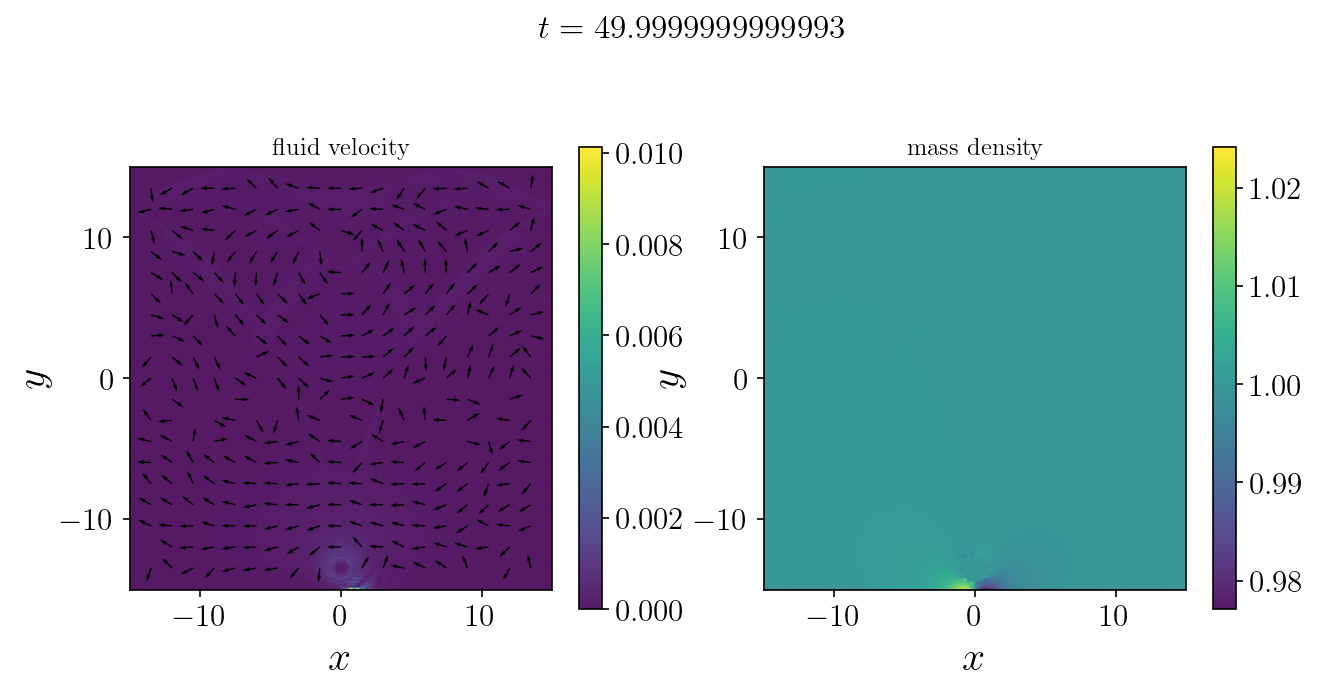

In [7]:
fig, axes = plt.subplots(1, 2, figsize = (10,5))

# Add a title for the whole figure
fig.suptitle(f"$t = {fluidDf.time.values[0]}$", fontsize=16)

# Create a meshgrid for plotting
x_unique = fluidDf['coordinate_x'].unique()
y_unique = fluidDf['coordinate_y'].unique()
X, Y = np.meshgrid(x_unique, y_unique)

cs = []

c = axes[0].pcolormesh(X, Y,
    np.sqrt(fluidDf.fluidVelocity_x**2 + fluidDf.fluidVelocity_y**2).unstack().values.transpose(),
    cmap = "viridis", alpha = 0.9
); cs.append(c);
axes[0].set_title('fluid velocity')

maskStep = int(len(x_unique)/20)
# Create a mask for filtering
mask = (fluidDf['coordinate_x'].isin(x_unique[::maskStep])) & (fluidDf['coordinate_y'].isin(y_unique[::maskStep])) & (
    (fluidDf.fluidVelocity_x**2 + fluidDf.fluidVelocity_y**2 > 1e-10)
)
# Filter the DataFrame
filtered_df = fluidDf[mask]

axes[0].quiver(
    filtered_df['coordinate_x'], 
    filtered_df['coordinate_y'], 
    (filtered_df.fluidVelocity_x / np.sqrt(filtered_df.fluidVelocity_x**2 + filtered_df.fluidVelocity_y**2)),
    (filtered_df.fluidVelocity_y / np.sqrt(filtered_df.fluidVelocity_x**2 + filtered_df.fluidVelocity_y**2)),
    scale = 30,
)

c = axes[1].pcolormesh(X,Y,
    fluidDf.massDensity.unstack().values.transpose(),
    vmin=min(fluidDf.query("massDensity > 1e-2").massDensity.values),
    cmap = "viridis", alpha = 0.9
); cs.append(c);
axes[1].set_title('mass density')

for i in range(2):
    ax = axes.flatten()[i]
    c = cs[i]
    ax.set_aspect('equal')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    cbar = fig.colorbar(c, ax=ax, shrink=.8)
    cbar.ax.yaxis.set_major_formatter(formatter)
    cbar.ax.yaxis.get_offset_text().set_fontsize(10)  # Adjust the font size if necessary

plt.show()

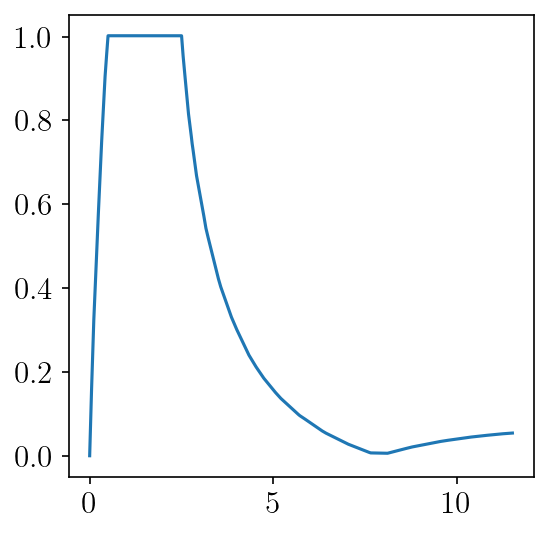

In [56]:
comsolResults = pd.read_csv('../data.lbm/VelocityProfile.csv', delimiter=',')
# comsolResults = np.fromfile('../data.lbm/VelocityProfile.dat', dtype=np.float64)  # Replace `dtype` with the appropriate data type
# comsolResults = pd.read_csv('../data.lbm/VelocityProfile.dat', sep='\s+')

# Replace 'filename.dat' with your actual file path
# comsolResults = pd.read_csv('../data.lbm/VelocityProfile.dat', sep= r"\\s+", 
#                             engine="python", comment='%', header=None)
# comsolResults = pd.read_csv("../data.lbm/VelocityProfile.dat", sep = "\\s+", comment = '%', names=["y", "v"])

# Rename the columns based on the table description
# comsolResults.columns = ['Arc length (µm)', 'Velocity magnitude']
plt.plot(comsolResults.coordinate_y, comsolResults.fluidVelocity_x)

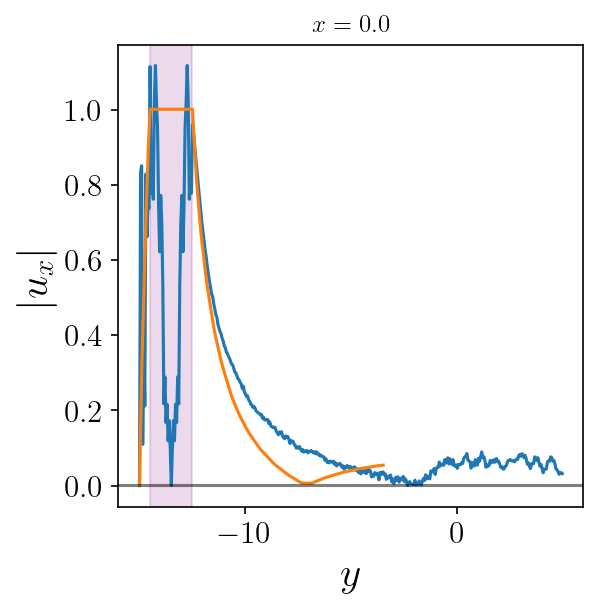

In [47]:
# encuentro el primer id_x tal que coordinate_x sea mayor o igual a la posición de la partícula
position_x = particleDf.query(f'tick == {tick}').position_x.values[0]
position_y = particleDf.query(f'tick == {tick}').position_y.values[0]
id = fluidDf.query(f"coordinate_x >= {position_x}").reset_index().iloc[0].filter(["id_x"]).values[0]

# ploteo v_x(y, x = 0)
v_x = fluidDf.loc[id].filter(["coordinate_y", "fluidVelocity_x"])

wallPosition = -15

plt.plot(v_x.query('coordinate_y < 5').coordinate_y, 1000*abs(v_x.query('coordinate_y < 5').fluidVelocity_x)) 
plt.plot(comsolResults.coordinate_y - 15, comsolResults.fluidVelocity_x) 
plt.xlabel("$y$")
plt.ylabel("$|u_x|$")
plt.title(f"$x = {fluidDf.query(f"id_x == {id}").iloc[0].filter(["coordinate_x"]).values[0]}$")
# plt.axvline(wallPosition, color = "k")
plt.axhline(0.001, color = 'k', alpha=0.5) # tangential velocity (μm/ms)
plt.axvspan(position_y-particleRadius, position_y+particleRadius, color='purple', alpha=0.15)  # Shade the sphere

plt.show()

# Tensor de estrés

In [9]:
stressDf = pd.read_csv(dir + "stressTensor.csv").set_index(["id_x","id_y"]).sort_index()

stressDf

tick  time  coordinate_x  coordinate_y  component_xx  component_yx  \
id_x id_y                                                                       
1    1     1000  50.0         -15.0        -15.00          -0.0          -0.0   
     2     1000  50.0         -15.0        -14.95          -0.0          -0.0   
     3     1000  50.0         -15.0        -14.90          -0.0          -0.0   
     4     1000  50.0         -15.0        -14.85          -0.0          -0.0   
     5     1000  50.0         -15.0        -14.80          -0.0          -0.0   
...         ...   ...           ...           ...           ...           ...   
601  597   1000  50.0          15.0         14.80          -0.0          -0.0   
     598   1000  50.0          15.0         14.85          -0.0          -0.0   
     599   1000  50.0          15.0         14.90          -0.0          -0.0   
     600   1000  50.0          15.0         14.95          -0.0          -0.0   
     601   1000  50.0          15.0         15.00          -0.0          -0.0   

           component_xy  component_yy  
id_x id_y                              
1    1             -0.0          -0.0  
     2             -0.0          -0.0  
     3             -0.0          -0.0  
     4             -0.0          -0.0  
     5             -0.0          -0.0  
...                 ...           ...  
601  597           -0.0          -0.0  
     598           -0.0          -0.0  
     599           -0.0          -0.0  
     600           -0.0          -0.0  
     601           -0.0          -0.0  

[361201 rows x 8 columns]

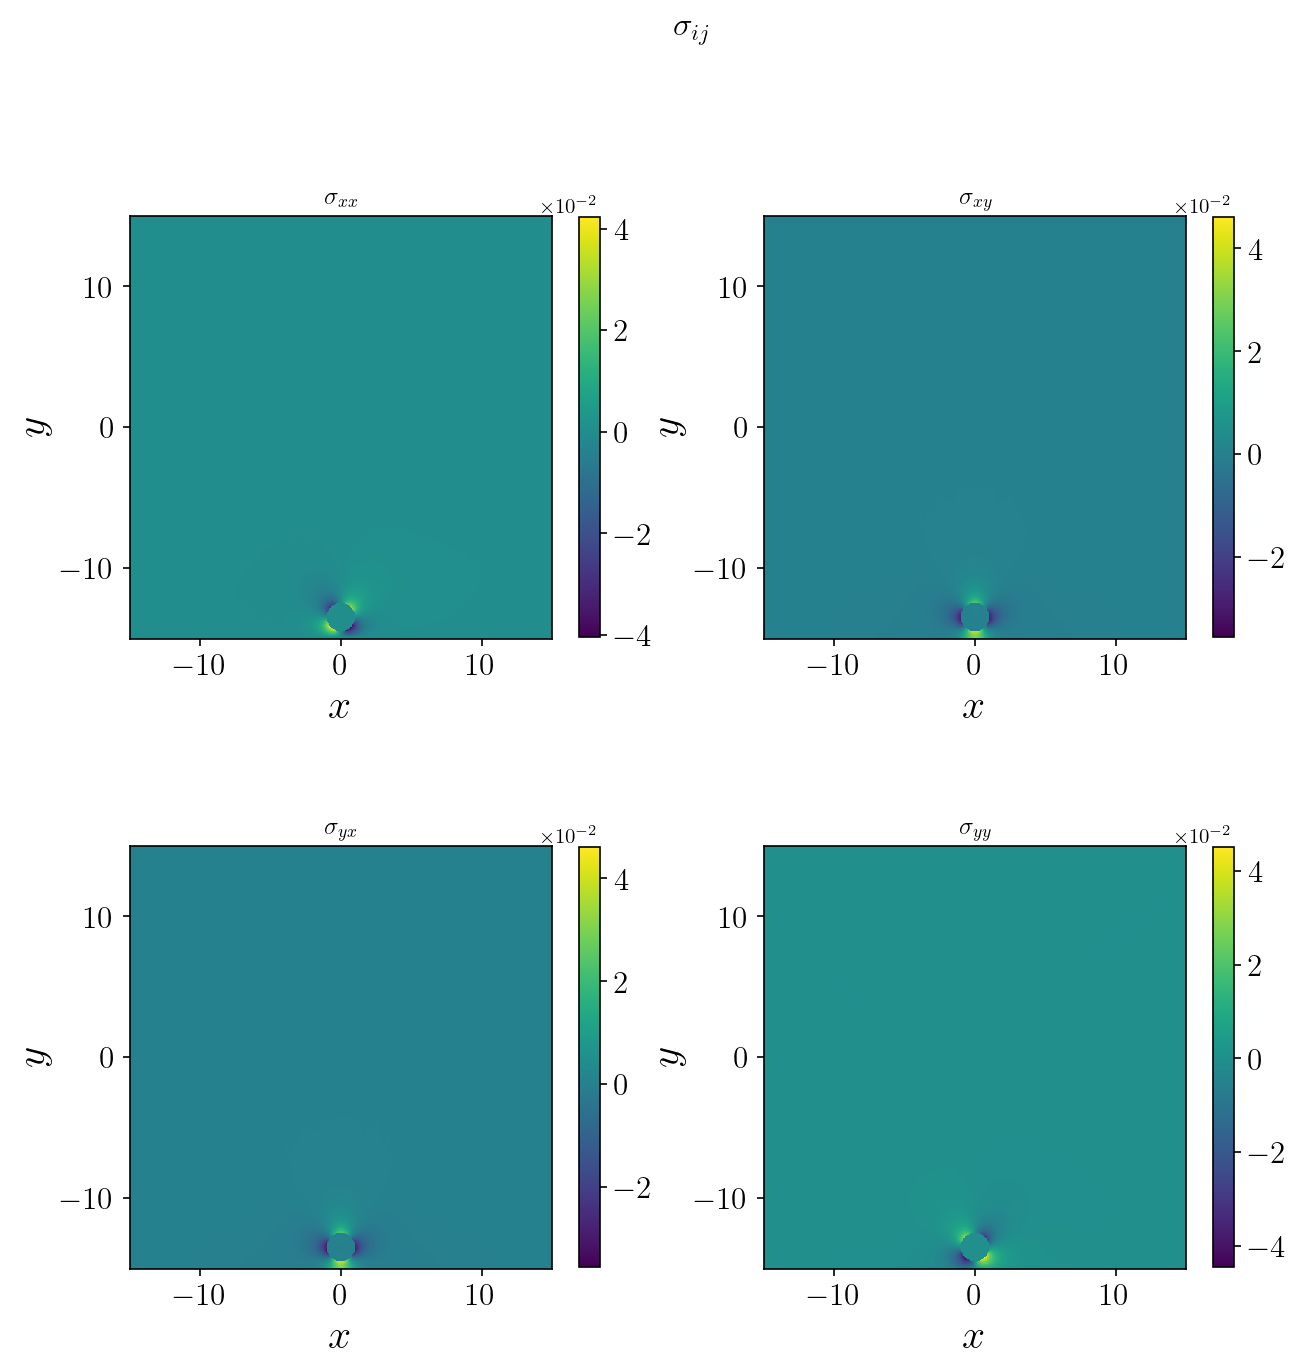

In [10]:
# setting up stuff
fig, axes = plt.subplots(2,2,figsize = (10,10))

# Add a title for the whole figure
fig.suptitle("$\\sigma_{ij}$", fontsize=16)

# Create a meshgrid for plotting
x_unique = stressDf['coordinate_x'].unique()
y_unique = stressDf['coordinate_y'].unique()
X, Y = np.meshgrid(x_unique, y_unique)

cs = []

# plotting
c = axes[0,0].pcolormesh(X,Y,stressDf["component_xx"].unstack().values.transpose()); cs.append(c);
axes[0,0].set_title("$\\sigma_{xx}$")

c = axes[0,1].pcolormesh(X,Y,stressDf["component_xy"].unstack().values.transpose()); cs.append(c);
axes[0,1].set_title("$\\sigma_{xy}$")

c = axes[1,0].pcolormesh(X,Y,stressDf["component_yx"].unstack().values.transpose()); cs.append(c);
axes[1,0].set_title("$\\sigma_{yx}$")

c = axes[1,1].pcolormesh(X,Y,stressDf["component_yy"].unstack().values.transpose()); cs.append(c);
axes[1,1].set_title("$\\sigma_{yy}$")


# for ax in axes.flat:
for i in range(4):
    ax = axes.flatten()[i]
    c = cs[i]
    ax.set_aspect('equal')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")    
    cbar = fig.colorbar(c, ax=ax, shrink=.8)
    cbar.ax.yaxis.set_major_formatter(formatter)
    cbar.ax.yaxis.get_offset_text().set_fontsize(10)  # Adjust the font size if necessary
#     ax.axhline(wallPosition, color = "k", alpha = 0.1)
#     ax.axhspan(-2, wallPosition, color='gray', alpha=0.1)  # Shade the wall

plt.show()

In [ ]:
# encuentro el primer id_x tal que coordinate_x sea mayor o igual a cero
id = stressDf.query("coordinate_x >= 0").reset_index().iloc[0].filter(["id_x"]).values[0]

# ploteo v_x(y, x = 0)
sigma_x = stressDf.loc[id].filter(["coordinate_y", "component_xx", "component_xy", "component_yx", "component_yy"])


# setting up stuff
fig, axes = plt.subplots(2,2,figsize = (10,10))

# Add a title for the whole figure
fig.suptitle("$\\sigma_{ij}$, with " f"$x = {stressDf.query(f"id_x == {id}").iloc[0].filter(["coordinate_x"]).values[0]}$", fontsize=16)

axes[0,0].plot(sigma_x.query("coordinate_y <= -3").coordinate_y, sigma_x.query("coordinate_y <= -3").component_xx) 
axes[0,0].set_ylabel("$\\sigma_{xx}$")    
axes[0,1].plot(sigma_x.query("coordinate_y <= -3").coordinate_y, sigma_x.query("coordinate_y <= -3").component_xy) 
axes[0,1].set_ylabel("$\\sigma_{xy}$")    
axes[1,0].plot(sigma_x.query("coordinate_y <= -3").coordinate_y, sigma_x.query("coordinate_y <= -3").component_yx) 
axes[1,0].set_ylabel("$\\sigma_{yx}$")    
axes[1,1].plot(sigma_x.query("coordinate_y <= -3").coordinate_y, sigma_x.query("coordinate_y <= -3").component_yy) 
axes[1,1].set_ylabel("$\\sigma_{yy}$")    

for ax in axes.flatten():
    ax.set_xlabel("$y$")
    ax.yaxis.set_major_formatter(formatter)
    ax.axvline(wallPosition, color = "k")
    ax.axvspan(-6+0.2, -6+1, color='purple', alpha=0.15)  # Shade the sphere

In [ ]:
# encuentro el primer id_x tal que coordinate_x sea mayor o igual a cero
id = stressDf.query("coordinate_y >= -5.4").reset_index().iloc[0].filter(["id_y"]).values[0]

sigma_y = stressDf.query(f"id_y == {id}").filter(["coordinate_x", "component_xx", "component_xy", "component_yx", "component_yy"])


# setting up stuff
fig, axes = plt.subplots(2,2,figsize = (10,10))

# Add a title for the whole figure
fig.suptitle("$\\sigma_{ij}$, with " f"$y = {stressDf.query(f"id_y == {id}").iloc[0].filter(["coordinate_y"]).values[0]}$", fontsize=16)

axes[0,0].plot(sigma_y.coordinate_x, sigma_y.component_xx) 
axes[0,0].set_ylabel("$\\sigma_{xx}$")    
axes[0,1].plot(sigma_y.coordinate_x, sigma_y.component_xy) 
axes[0,1].set_ylabel("$\\sigma_{xy}$")    
axes[1,0].plot(sigma_y.coordinate_x, sigma_y.component_yx) 
axes[1,0].set_ylabel("$\\sigma_{yx}$")    
axes[1,1].plot(sigma_y.coordinate_x, sigma_y.component_yy) 
axes[1,1].set_ylabel("$\\sigma_{yy}$")    

for ax in axes.flatten():
    ax.set_xlabel("$x$")
    ax.yaxis.set_major_formatter(formatter)
    ax.axvspan(-0.4, 0.4, color='purple', alpha=0.15)  # Shade the sphere